**Please note this jupyter notebook is in Julia, if you are looking for a python version of Gillespie Algorithm, please click the following link of epidemic outbreak project.**

https://github.com/je-suis-tm/graph-theory/blob/master/Epidemic%20Outbreak%20project/gillespie%20algorithm.ipynb

&nbsp;
# Habitat Occupancy
&nbsp;

Traditionally in ecology, metapopulation model is used to map out the patchy habitat occupancy and extinction. It only requires one ordinary differential equation to monitor a single species. One of the big drawbacks is its landscape connectivity. With avant-garde complex network, we can incorporate spatial structure into the deterministic system to create an agent-based simulation. There are two types of scenarios, mainland-island and inter-island. In this case, we take the latter approach which is why we also involve population dynamic into the complex system. Additionally, we maintain the homogenous habitat quality to reduce workload.

&nbsp;
### Levins Model
&nbsp;

`dP/dt=cP(1-P)-eP`

where

`P` denotes the fraction of occupied patchy habitat, 1 is the total sum of available patchy habitats

`c` denotes colonization rate which is proportional to number of occupied patchy habitats

`e` denotes extinction rate of occupied patchy habitat

&nbsp;
### Agent-based Modelling
&nbsp;

`dPi/dt=(α-δ)Pi+∑Aijϵij(Pj-Pi)`

where

`Pi` denotes the population of habitat `i`

`α` denotes crude birth rate, assume this species can carry sperm and switch gender, as long as it is alive it can reproduce, lol

`δ` denotes crude death rate, it is density-independent in this case

`Aij` denotes adjacency matrix of a random geometric graph

`ϵij` denotes emigration rate from habitat `i` to habitat `j`, to make our lives easier, emigration rate is identical in this case, `ϵij=ϵ, ∀i,j`

&nbsp;

In [1]:
using Plots

In [2]:
cd("h:/")

In [3]:
#create random geometric graph
#return the adjacency matrix
#the raison d'être of random geometric graph is
#its similarity with real geographic features
#where places are more likely to be connected within certain radius
function create_rgg(num_of_habitats,radius)
    
    #generate 2d coordinates from uniform distribution
    habitats=[(rand(),rand()) for _ in 1:num_of_habitats]
    
    #create adjacency matrix
    adjacency=Any[Float32[0.0 for _ in 1:num_of_habitats] for _ in 1:num_of_habitats]

    for i in 1:num_of_habitats

        for j in i+1:num_of_habitats
            
            #compute euclidean distance
            distance=sqrt(sum([(habitats[i][ii]-habitats[j][ii])^2 for ii in 1:2]))
            
            #if euclidean distance smaller than preset radius
            #two vertices will be connected
            if distance<=radius
                
                #undirected
                adjacency[i][j]=distance
                adjacency[j][i]=distance

            end

        end

    end
   
    return habitats,adjacency
    
end

create_rgg (generic function with 1 method)

In [4]:
#using gillespie algorithm to simulate agent based levins model
function levins_model(adjacency,params)
    
    #unpack
    t,tmax,crude_birth_rate,num_of_habitats,crude_death_rate,emigration_rate,population=params
    
    
    #initial starting point for all agents
    startingpoint=rand(1:num_of_habitats)

    #keep track of all agents
    #each agent has num_of_habitats+1 values
    #0 denotes deceased
    #1:num_of_habitats denotes the current habitat
    status_agents=Any[Int32[startingpoint for _ in 1:population]]

    #keep track of population inside habitats
    status_habitats=Any[Int32[0 for _ in 1:num_of_habitats]]
    status_habitats[1][startingpoint]=population
    
    #create timeline
    timeline=Float32[t]

    while t<tmax

        #update total number of agents
        #update status of agents
        #update status of habitats
        population=length([i for i in status_agents[end] if i!=0])
        agents=[i for i in status_agents[end]]
        habitats=[i for i in status_habitats[end]]

        #compute propensity for birth,death,emigration
        propensity1=crude_birth_rate*population
        propensity2=crude_death_rate*population
        propensity3=emigration_rate*population
        propensity_all=propensity1+propensity2+propensity3

        #tau leaping
        τ=-log(rand())/propensity_all
        t+=τ

        #find all alive agents
        #randomly select one for the following events
        #reproduce,die or migrate
        alive=[i for i in 1:population if agents[i]!=0]
        selected=rand(alive)
        
        random_prob=rand()

        #birth
        if random_prob<propensity1/propensity_all

            push!(agents,agents[selected])

        #death
        elseif propensity1/propensity_all<random_prob<(propensity1+propensity2)/propensity_all

            agents[selected]=0

        #migration
        else        

            #potential destination is determined by graph structure            
            migration=[i for i in 1:length(adjacency) if adjacency[agents[selected]][i]!=0]
            agents[selected]=rand(migration)

        end

        #keep track of agent status change                            
        push!(status_agents,agents)

        #keep track of habitat change                            
        for i in 1:length(habitats)

            habitats[i]=count(x->(x==i),agents)

        end

        push!(status_habitats,habitats)
        
        #update timeline
        push!(timeline,t)

    end
    
    return timeline,status_agents,status_habitats
                                
end

levins_model (generic function with 1 method)

In [5]:
#this technique is like counting sort
#check the link below for more details
# https://github.com/je-suis-tm/search-and-sort/blob/master/counting%20sort.jl
#the idea is to transform float timeline to int timeline
function cleanse_matrix(timeline,status_agents,status_habitats)
    
    #get ceiling of each τ
    ceiling=[ceil(i) for i in timeline]
    
    #count the frequency of each τ
    find_ind=Int32[]

    for i in unique(ceiling)

        push!(find_ind,count(x->(x==i),ceiling))

    end
    
    #cumsum to select the desired index
    find_ind=cumsum(find_ind)

    status_agents_output=status_agents[find_ind]
    status_habitats_output=status_habitats[find_ind]
    timeline_output=timeline[find_ind]
    timeline_output=[ceil(i) for i in timeline_output]
    
    return timeline_output,status_agents_output,status_habitats_output
    
end

cleanse_matrix (generic function with 1 method)

In [6]:
#visualize levins model by animation
#using scatter and line to map out the random graph
function viz(timeline,status_habitats,adjacency,
        coordinates,titlename,filename)
    
    anim=@animate for ind in 1:length(timeline)

        pic=plot(legend=false,grid=false,axis=false,
            title="$titlename\nt=$ind")

        #create edges from adjacency matrix
        for i in 1:β

            for j in i+1:β

                if adjacency[i][j]!=0

                    plot!([coordinates[i][1],coordinates[j][1]],
                        [coordinates[i][2],coordinates[j][2]],color="grey")

                end

            end

        end

        #create vertices
        #vertex color is based upon the population of the habitat
        scatter!([i[1] for i in coordinates],[i[2] for i in coordinates],
            markersize=10,zcolor=status_habitats[ind],
            m=cgrad([:white,:red,:brown,:black]))

        pic

    end

    gif(anim,filename,fps=1)
    
end

viz (generic function with 1 method)

In [7]:
#crude birth rate
α=0.01

#crude death rate
δ=0.005

#emigration rate
ϵ=0.3

#maximum elapsed time
tmax=30

#beginning time
t=0

#initial population
ρ=500

#number of habitats
β=50

#radius threshold
γ=0.5

#packing
params=(t,tmax,α,β,δ,ϵ,ρ)

(0, 30, 0.01, 50, 0.005, 0.3, 500)

┌ Info: Saved animation to 
│   fn = h:\levins model.gif
└ @ Plots C:\Users\T.M.\.julia\packages\Plots\Xnzc7\src\animation.jl:104


Plots.AnimatedGif("h:\\levins model.gif")
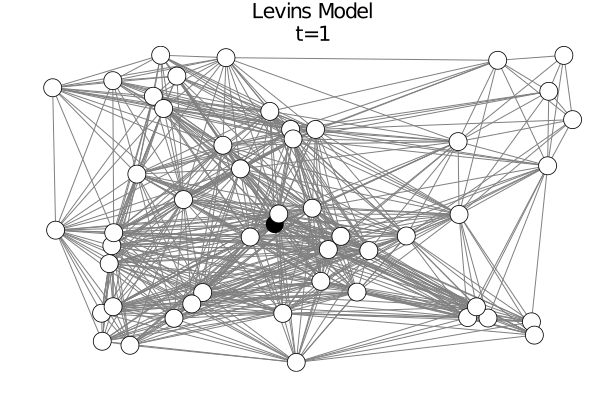

In [8]:
#generate random geometric graph
coordinates,adjacency=create_rgg(β,γ)

#get simulation result
timeline,status_agents,status_habitats=levins_model(adjacency,params)

#cleanse data
timeline,status_agents,status_habitats=cleanse_matrix(timeline,
    status_agents,status_habitats)

#viz
viz(timeline,status_habitats,adjacency,
    coordinates,"Levins Model","levins model.gif")

Imagine the random geometric graph as a huge island, like Corsica. The habitat occupancy is the territory expansion of Corsican Mafias. If you have watched Mafiosa by Canal+, you will find it easy to understand. We are simulating how Sandra Paoli’s clan gradually take over Corse. The starting point is Bastia, Haute-Corse. They eventually move towards Ajaccio, Corse-du-Sud (no Marseille in inter-island model). We are able to witness the rapid habitat occupancy because the preset parameters are relatively large.

&nbsp;
### Further Reading
&nbsp;

1. Colizza V, Vespignani A (2007)

	Epidemic Modeling In Metapopulation Systems With Heterogeneous Coupling Pattern Theory And Simulations

	https://arxiv.org/abs/0706.3647

	*This paper is the Bible of metapopulation in epidemiology. The mobility rate in metapopulation model can be categorized into traffic-dependent and population-dependent rather than our fixed value.*

&nbsp;
2. Hanski IA, Gaggiotti OE (2004)

	Ecology, Genetics And Evolution Of Metapopulations

	https://www.elsevier.com/books/ecology-genetics-and-evolution-of-metapopulations/hanski/978-0-12-323448-3

	*Hanski is one of the most influential ecologists in the research field of metapopulation. A textbook written by him is definitely worth reading. You will find Levins Model on page 77.*

&nbsp;
3. Keeling MJ (2002)

	Using Individual-based Simulations To Test The Levins Metapopulation Paradigm

	https://www.semanticscholar.org/paper/Using-individual-based-simulations-to-test-the-Keeling/9d9fab47a774ff107f8ea2b357a68c5d26be6d9a

	*The ordinary differential equation of agent-based model in this script draws inspiration from this particular paper.*